In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  %pip install --quiet git+https://github.com/raultruco/cryptowatson-indicators#egg=cryptowatson-indicators

import backtrader as bt
from cryptowatson_indicators.datas import TickerDataSource
from cryptowatson_indicators.backtrader import RebalanceStrategy, WeightedDCAStrategy, DCAStrategy, HodlStrategy, FngBandIndicatorWrapper, RainbowBandIndicatorWrapper
from tabulate import tabulate
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200
# %matplotlib inline
%matplotlib widget

# Global variables
# Data sources
ticker_data_source = TickerDataSource()


# Compare strategies

Usage...

### Variables

In [2]:
# Common variables
# ticker_symbol        = "BTCUSDT"    # currently only works with BTCUSDT
start                = '01/01/2021'   # start date of the simulation. Ex: '01/08/2020' or None
end                  = None # '31/12/2021'           # end date of the simulation. Ex: '01/08/2020' or None
initial_cash         = 10000.0        # initial broker cash. Default 10000 usd
min_order_period     = 3              # Minimum period in days to place orders
base_buy_amount  = 100            # Amount purchased in standard DCA
indicator_ma_class = bt.ind.WeightedMovingAverage
indicator_ma_period = 3            # MA period of the indicator index

# Specific for Fear and greed indicator
fng_weighted_multipliers = [1.5, 1.25, 1, 0.75, 0.5]    # buy amount multipliers (weighted) for each band
fng_rebalance_percents   = [85, 65, 50, 15, 10]         # rebalance percentages of BTC / total for each band

# Specific for Rainbow indicator
rwa_weighted_multipliers = [0, 0.1, 0.2, 0.3, 0.5, 0.8, 1.3, 2.1, 3.4]
rwa_rebalance_percents = [10, 20, 30, 40, 50, 60, 70, 80, 90]

# Other options
log_progress         = False
plot_results         = True

### Run strategies!

In [3]:
simulation_results = list()
simulation_brokers = list()

def run(strategyClass, simulation_data_feed, **kwargs):
    global simulation_results
    global simulation_brokers

    cerebro = bt.Cerebro(stdstats=False, runonce=True)
    cerebro.broker.set_coc(True)

    # Add strategy
    cerebro.addstrategy(strategyClass, **kwargs)

    # Add data feeds
    cerebro.adddata(simulation_data_feed)

    # Set broker initial cash
    cerebro.broker.setcash(initial_cash)

    # Run simulation!
    cerebro_results = cerebro.run()     # runonce=False, exactbars=True (optimization)
    print(f"✔ Done {str(cerebro_results[0])}")

    # Save results to show them at the end
    simulation_results.append(cerebro_results[0])
    simulation_brokers.append(cerebro.getbroker())


# Weighted Av strategy with Fear and Greed indicator
run( \
    strategyClass=WeightedDCAStrategy, \
    simulation_data_feed=ticker_data_source.to_backtrade_feed(start, end), \
    base_buy_amount=base_buy_amount, \
    min_order_period=min_order_period, \
    weighted_multipliers=fng_weighted_multipliers, \
    indicator_class=FngBandIndicatorWrapper, \
    ma_class=indicator_ma_class, \
    log=log_progress, \
)

# Rainbow Weighted Av strategy
run( \
    strategyClass=WeightedDCAStrategy, \
    simulation_data_feed=ticker_data_source.to_backtrade_feed(start, end), \
    base_buy_amount=base_buy_amount, \
    min_order_period=min_order_period, \
    weighted_multipliers=rwa_weighted_multipliers, \
    indicator_class=RainbowBandIndicatorWrapper, \
    ma_class=indicator_ma_class, \
    log=log_progress, \
)

# Fear and Greed Rebalance strategy
run( \
    strategyClass=RebalanceStrategy, \
    simulation_data_feed=ticker_data_source.to_backtrade_feed(start, end), \
    min_order_period=min_order_period, \
    rebalance_percents=fng_rebalance_percents, \
    indicator_class=FngBandIndicatorWrapper, \
    ma_class=indicator_ma_class, \
    ma_period=indicator_ma_period, \
    log=log_progress, \
)

# Rainbow Rebalance strategy
run( \
    strategyClass=RebalanceStrategy, \
    simulation_data_feed=ticker_data_source.to_backtrade_feed(start, end), \
    min_order_period=min_order_period, \
    rebalance_percents=rwa_rebalance_percents, \
    indicator_class=RainbowBandIndicatorWrapper, \
    ma_class=indicator_ma_class, \
    ma_period=indicator_ma_period, \
    log=log_progress, \
)

# Standard DCA
run( \
    strategyClass=DCAStrategy, \
    simulation_data_feed=ticker_data_source.to_backtrade_feed(start, end), \
    buy_amount=base_buy_amount, \
    min_order_period=min_order_period, \
    log=log_progress, \
)

# HODL
run( \
    strategyClass=HodlStrategy, \
    simulation_data_feed=ticker_data_source.to_backtrade_feed(start, end), \
    percent=100, \
    log=log_progress, \
)


✔ Done Weighted DCA Fear and Greed
✔ Done Weighted DCA Rainbow band
✔ Done Rebalance Fear and Greed
✔ Done Rebalance Rainbow band
✔ Done DCA 100.00$
✔ Done HODL 100%


### Show the results

Simulation,Started (USD),Ended (USD),PnL (USD),PnL %
Weighted DCA Fear and Greed,10000,5076.19,-4923.81,-49.24
Weighted DCA Rainbow band,10000,4729.47,-5270.53,-52.71
Rebalance Fear and Greed,10000,6580.87,-3419.13,-34.19
Rebalance Rainbow band,10000,7149.6,-2850.4,-28.5
DCA 100.00$,10000,4965.23,-5034.77,-50.35
HODL 100%,10000,7452.04,-2547.96,-25.48


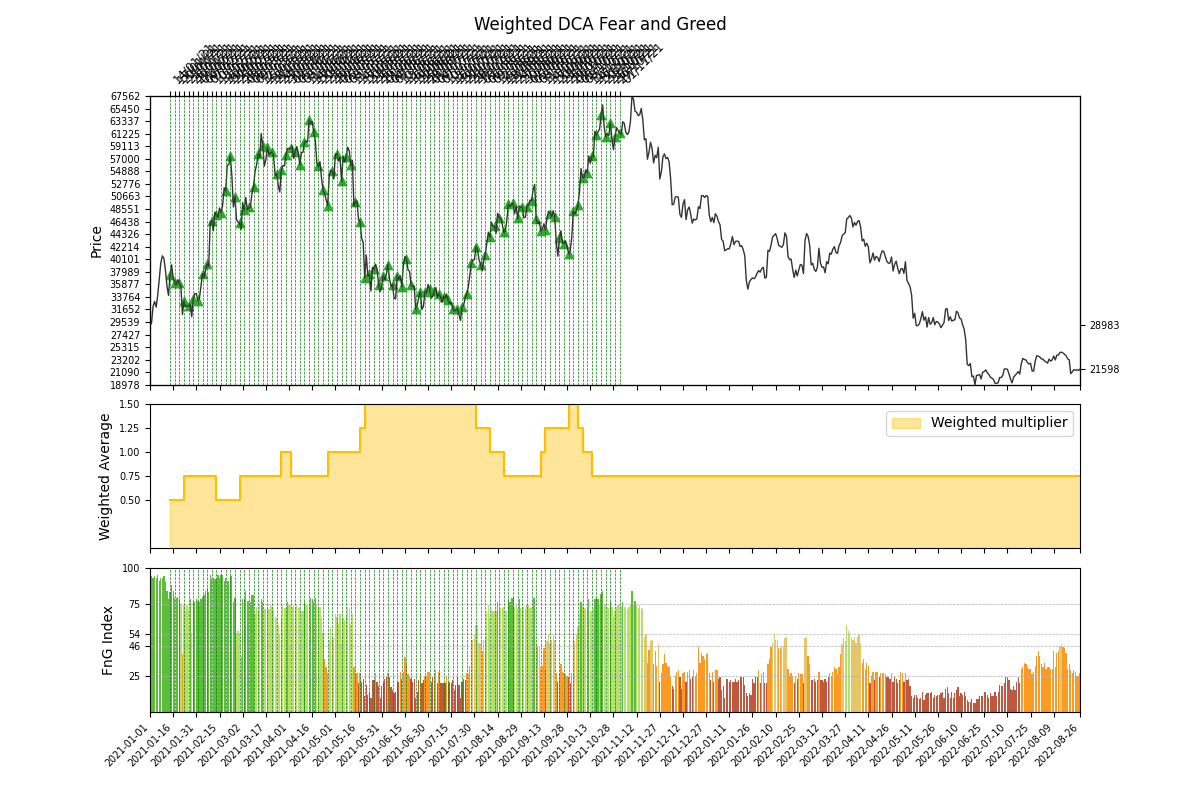

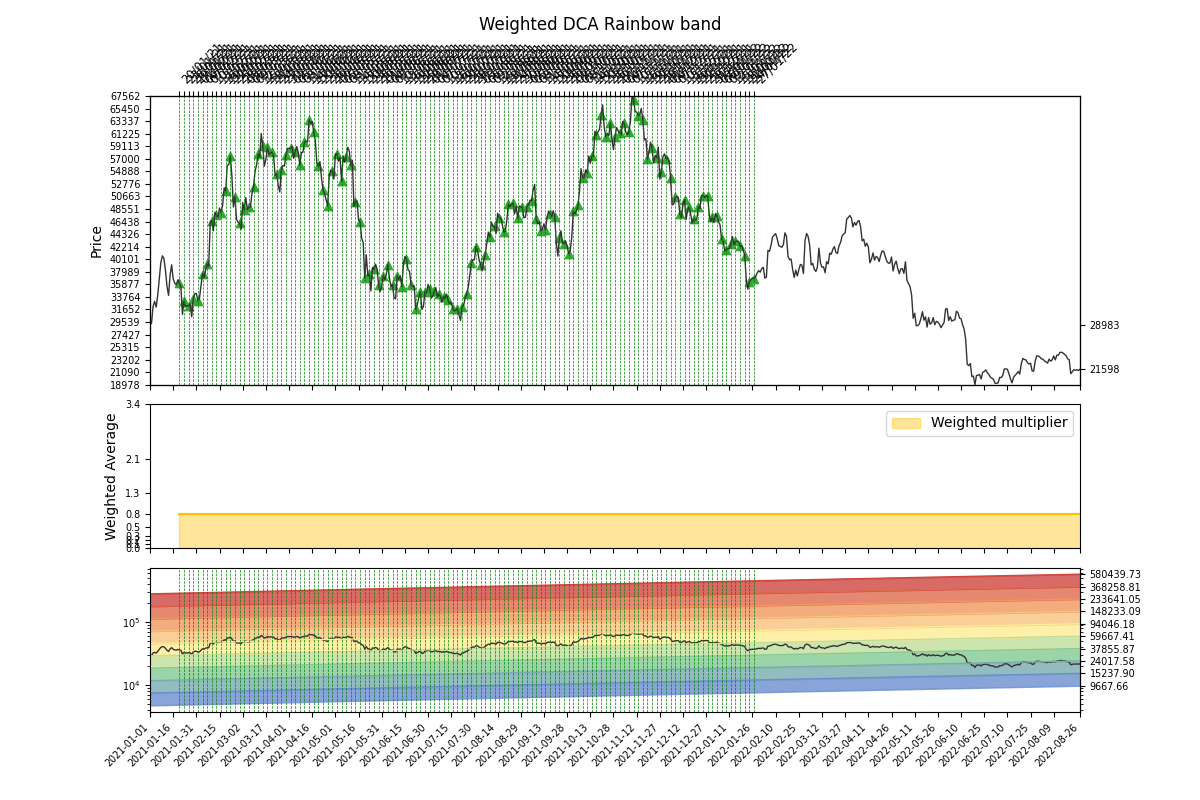

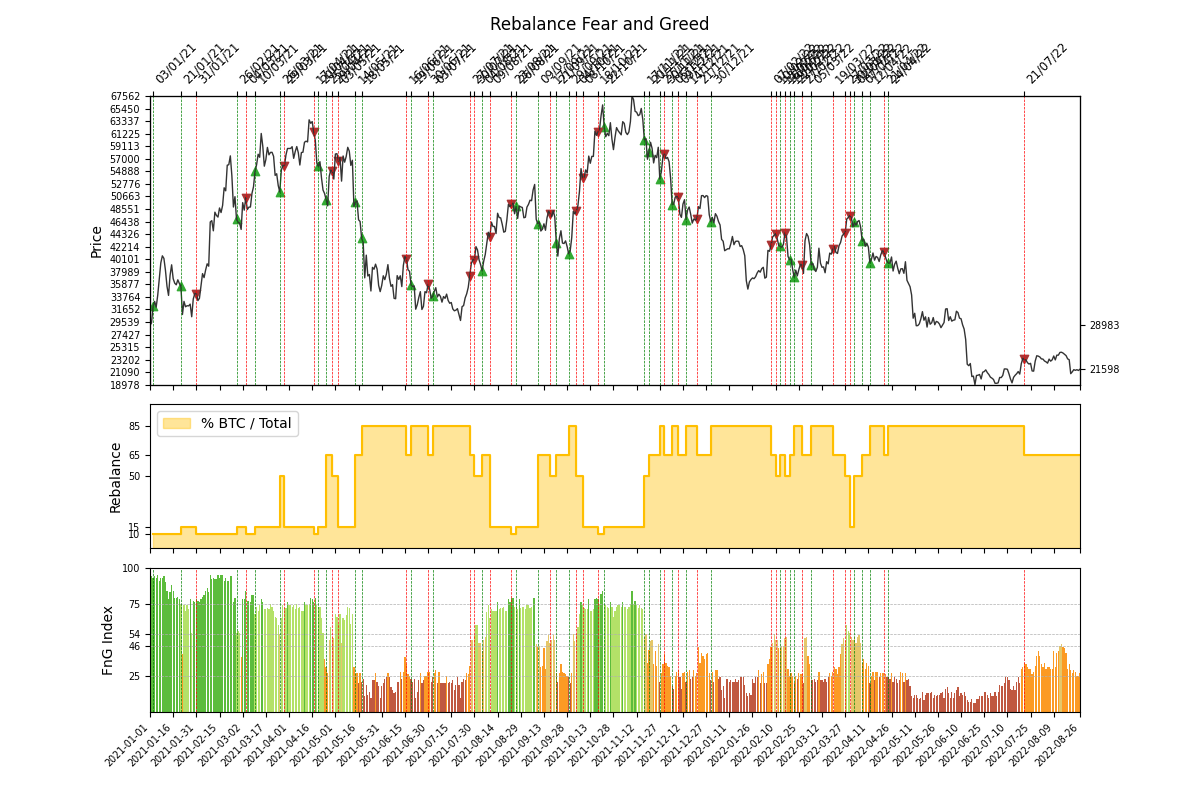

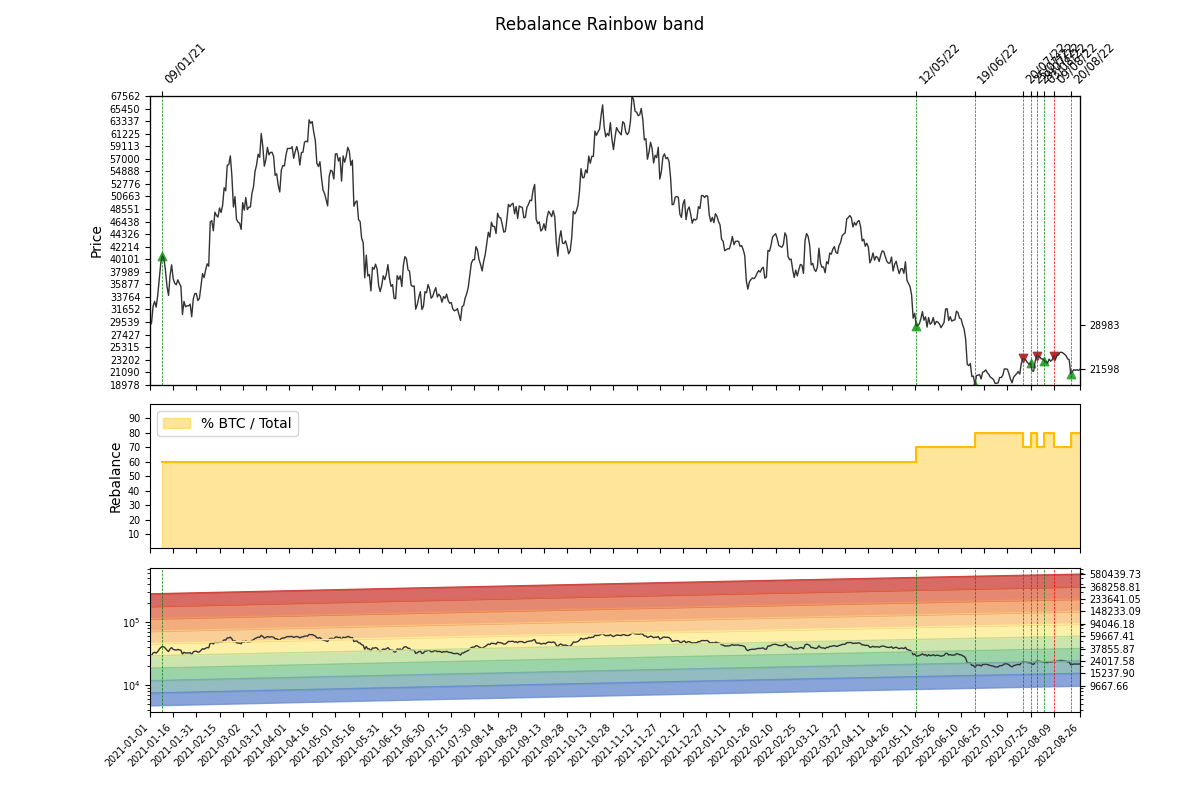

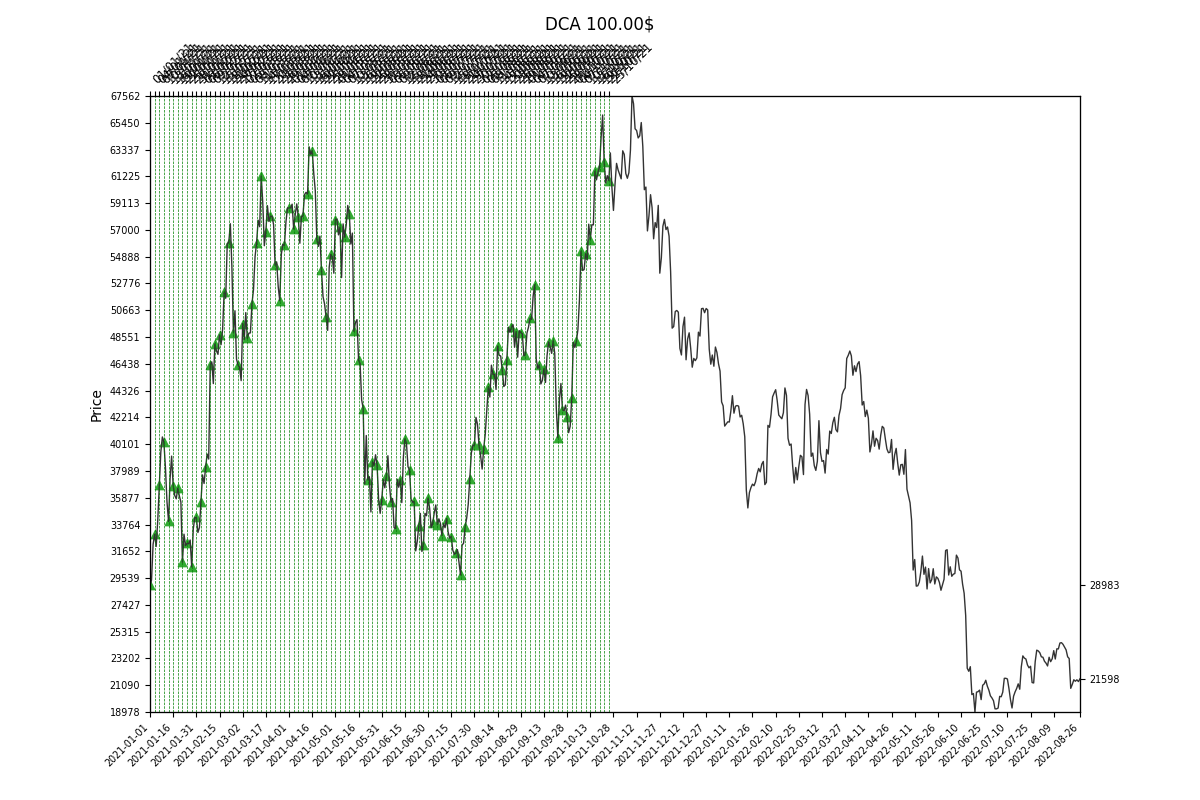

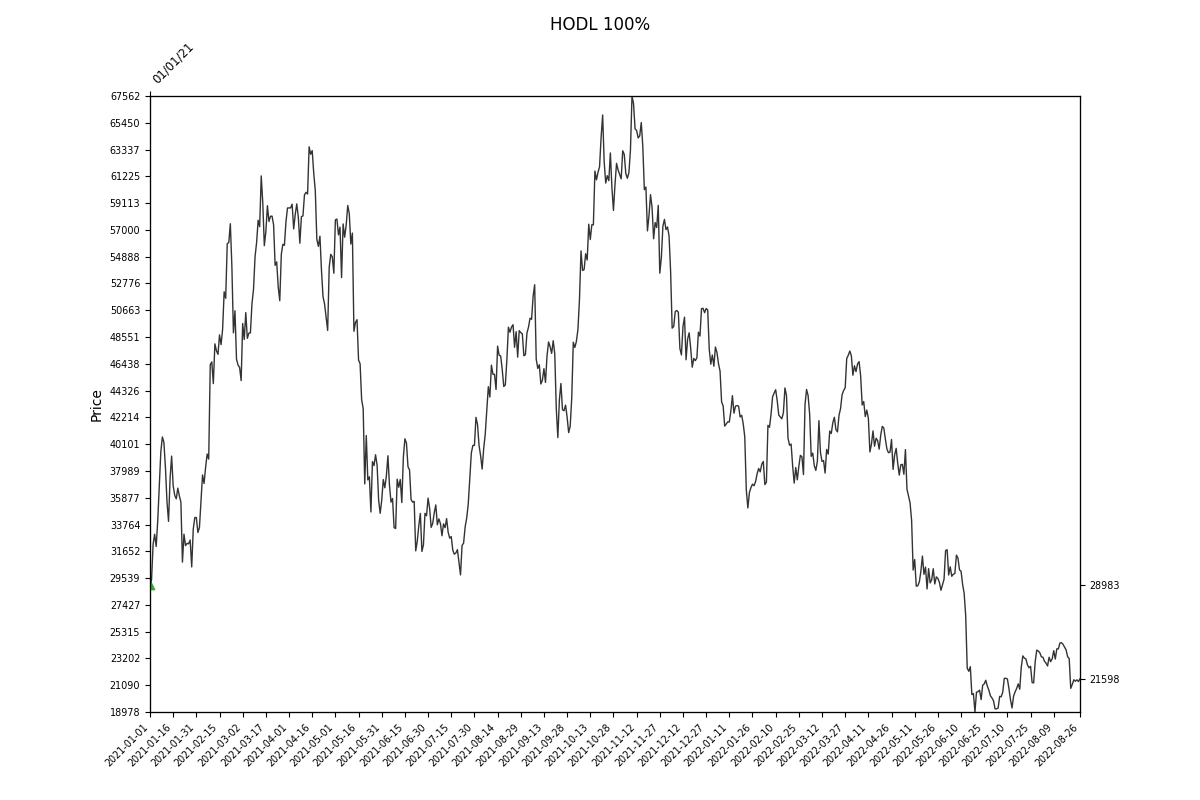

In [4]:

results_table = list()
for i in range(0, len(simulation_results)):
    strategy = simulation_results[i]
    broker = simulation_brokers[i]

    start_portfolio_value = initial_cash
    end_cash = broker.getcash()
    end_portfolio_value = broker.getvalue()     # Total value in USDT
    end_position = broker.getposition(data=strategy.data)

    pnl_value = end_portfolio_value - start_portfolio_value
    pnl_percent = (pnl_value / start_portfolio_value) * 100
    
    html_pnl_value = f"<span style='color:{'red' if pnl_value < 0 else 'green'}'>{'-' if pnl_value < 0 else '+'}{round(abs(pnl_value), 2)}<span>"
    html_pnl_percent = f"<span style='color:{'red' if pnl_percent < 0 else 'green'}'>{'-' if pnl_percent < 0 else '+'}{round(abs(pnl_percent), 2)}<span>"

    results_table.append([str(strategy), round(start_portfolio_value, 2), round(end_portfolio_value, 2), html_pnl_value, html_pnl_percent])


display(tabulate(results_table, headers=["Simulation", "Started (USD)", "Ended (USD)", "PnL (USD)", "PnL %"], tablefmt="unsafehtml"))

if plot_results:
    for i in range(0, len(simulation_results)):
        strategy = simulation_results[i]
        strategy.plot()
else:
    simulation_results[-1].plot()